In [ ]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np

from functools import partial
import tensorflow as tf
from alibi_detect.cd import MMDDrift
from alibi_detect.saving import save_detector, load_detector
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer
from alibi_detect.cd.tensorflow import preprocess_drift
import pprint
pp = pprint.PrettyPrinter()

from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [ ]:
# function to retrieve images from one dataset
def get_dataset_images(dataset_path: str):
    imgs = []
    imgs_label = []
    for dataset_class in os.listdir(dataset_path):
        for class_img_file in os.listdir(os.path.join(dataset_path, dataset_class)):
            img = cv2.imread(os.path.join(dataset_path, dataset_class, class_img_file))
            imgs.append(img)
            imgs_label.append(dataset_class)
    return imgs, imgs_label

In [ ]:
# X1, Y1 & X2, Y2 represent images and labels from source training datasets; X3, Y3 represent images and labels from target dataset 
X1, Y1, X2, Y2, X3, Y3 = [], [], [], [], [], []

# call function to retrieve images and labels
X1, Y1 = get_dataset_images("Drift Check Datasets\Concrete")
X2, Y2 = get_dataset_images("Drift Check Datasets\Marble")
X3, Y3 = get_dataset_images("Drift Check Datasets\MVTEC")

# testing images from concrete dataset
TX1, _ = get_dataset_images("Drift Check Datasets\Test")


### Datasets Drift Detection using Maximum Mean Discrepancy (MMD)

In [ ]:
# image resizing and scaling 
X1_MMD = np.array([cv2.resize(img, (32, 32)) for img in X1]).astype('float32') / 255
X2_MMD = np.array([cv2.resize(img, (32, 32)) for img in X2]).astype('float32') / 255
X3_MMD = np.array([cv2.resize(img, (32, 32)) for img in X3]).astype('float32') / 255

TX1_MMD = np.array([cv2.resize(img, (32, 32)) for img in TX1]).astype('float32') / 255

In [ ]:
tf.random.set_seed(0)

encoder_net = tf.keras.Sequential(
    [
        InputLayer(input_shape=(32, 32, 3)),
        Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
        Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
        Flatten(),
        Dense(32,)
    ]
)

preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=170)

# detector built using data from X1 (source dataset 1)
drift_detector_X1 = MMDDrift(X1_MMD, backend='tensorflow', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=30)
# detector built using data from X2 (source dataset 2)
drift_detector_X2 = MMDDrift(X2_MMD, backend='tensorflow', p_val=.05, preprocess_fn=preprocess_fn, n_permutations=30)

In [469]:
# predict on target dataset to check if drift occurs, is_drift: 0 means NO drift occurs; is_drift: 1 means drift occurs
# X3_MMD TX1_MMD
pp.pprint(drift_detector_X1.predict(X3_MMD))
pp.pprint(drift_detector_X2.predict(X3_MMD))

{'data': {'distance': 0.46516928,
          'distance_threshold': 0.0017219186,
          'is_drift': 1,
          'p_val': 0.0,
          'threshold': 0.05},
 'meta': {'backend': 'tensorflow',
          'data_type': None,
          'detector_type': 'drift',
          'name': 'MMDDriftTF',
          'online': False,
          'version': '0.10.0'}}
{'data': {'distance': 0.5995882,
          'distance_threshold': 0.0025924742,
          'is_drift': 1,
          'p_val': 0.0,
          'threshold': 0.05},
 'meta': {'backend': 'tensorflow',
          'data_type': None,
          'detector_type': 'drift',
          'name': 'MMDDriftTF',
          'online': False,
          'version': '0.10.0'}}


### Datasets Drift Visualisation using Dense Vectors

In [ ]:
# the pre-trained model to obtain image dense vector from
model = resnet50.ResNet50(weights='imagenet')
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer('avg_pool').output)

# convert image to dense vector
def img2vec(img):
    img = np.expand_dims(img, axis=0)
    img = resnet50.preprocess_input(img)
    intermediate_output = intermediate_layer_model.predict(img)
    return intermediate_output[0]

In [ ]:
# image resizing and scaling
X1_vis = np.array([cv2.resize(img, (224, 224)) for img in X1]).astype('float32') / 255
X2_vis = np.array([cv2.resize(img, (224, 224)) for img in X2]).astype('float32') / 255
X3_vis = np.array([cv2.resize(img, (224, 224)) for img in X3]).astype('float32') / 255

# obtained dense vector of all the images
vectors = []
for X in [X1_vis, X2_vis, X3_vis]:
    for img in X:
        vectors.append(img2vec(img))

c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Owner\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1078 samples in 0.000s...
[t-SNE] Computed neighbors for 1078 samples in 0.058s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1078
[t-SNE] Computed conditional probabilities for sample 1078 / 1078
[t-SNE] Mean sigma: 0.035714
[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.273659
[t-SNE] KL divergence after 1000 iterations: 0.652245


<AxesSubplot:xlabel='tsne-one', ylabel='tsne-two'>

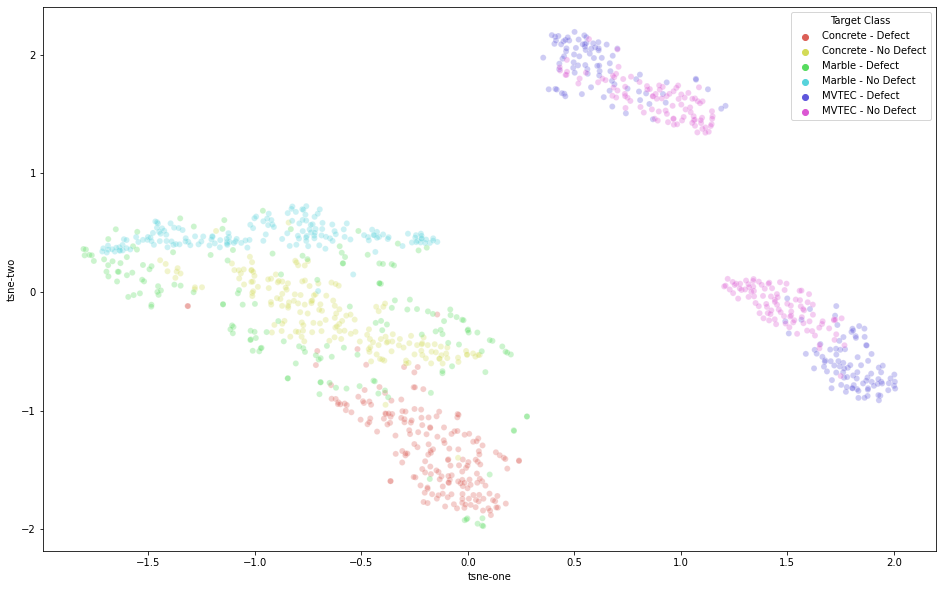

In [470]:
# visualize dense vectors
pca = PCA(n_components=25)
pca_result = pca.fit_transform(vectors)

tsne = TSNE(n_components=2, verbose=1)
tsne_pca = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_pca)

vis_info = pd.DataFrame()
vis_info['Target Class'] = Y1 + Y2 + Y3
vis_info['tsne-one'] = tsne_result_scaled[:,0]
vis_info['tsne-two'] = tsne_result_scaled[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-one", y="tsne-two",
    hue="Target Class",
    palette=sns.color_palette('hls', len(vis_info['Target Class'].unique())),
    data=vis_info,
    legend="full",
    alpha=0.3
)